In [1]:
import torch
import numpy as np
import tensorly as tl
import scipy
import scipy.signal
import matplotlib.pyplot as plt

print(torch.cuda.is_available)
print(torch.cuda.device_count)
print(torch.cuda.current_device)
print(torch.cuda.get_device_name(0))

<function is_available at 0x000001995F689EA0>
<function current_device at 0x000001995FA7BD00>
Quadro P2000


In [30]:
# define files to import from Matlab
Xname=r'C:\Users\sabatini\Documents\tensor.mat'
yname=r'C:\Users\sabatini\Documents\allLabels.mat'
timename=r'C:\Users\sabatini\Documents\timepoints_for_tensor.mat'
    
# read data from files
X=scipy.io.loadmat(Xname)
y=scipy.io.loadmat(yname)
timepoints=scipy.io.loadmat(timename)
X = X['tensor']
y = y['allLabels']
timepoints = timepoints['timepoints_for_tensor']
timepoints=np.squeeze(timepoints)
time_step = np.median(np.diff(timepoints, 1, 0))
print(timepoints)
print(time_step)

[0.   0.24 0.48 0.72 0.96 1.2  1.44 1.68 1.92 2.16 2.4  2.64 2.88 3.12
 3.36]
0.24


In [31]:
import sys
sys.path.append(r'C:\Users\sabatini\Documents\GitHub')
%load_ext autoreload
%autoreload 2
from tensor_regression import multinomial_tensor_regression_hierarchical as mtr

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [32]:
torch.manual_seed(321)
np.random.seed(321)

# X_dims_fake = [2000, 500, 500]
# nClasses_fake = 5

# y_true  = np.random.randint(0, nClasses_fake, X_dims_fake[0])
# y_true_oneHot = mtr.idx_to_oneHot(y, 4)

# Xcp_underlying_fake = [
#                       torch.rand(X_dims_fake[0], 4)-0.5,
#                       torch.vstack([torch.sin(torch.linspace(0, 140, X_dims_fake[1])),
#                                     torch.cos(torch.linspace(2,19,X_dims_fake[1])),
#                                     torch.linspace(0,1,X_dims_fake[1]),
#                                     torch.cos(torch.linspace(0,17,X_dims_fake[1])) >0]).T ,
#                       torch.tensor(scipy.signal.savgol_filter(np.random.rand(X_dims_fake[2], 4), 15, 3, axis=0))-0.5,
#                     ]
# Bcp_underlying_fake = Xcp_underlying_fake[1:] + [torch.rand(nClasses_fake, 4) -0.5]

tl.set_backend('pytorch')
# X_fake = tl.cp_tensor.cp_to_tensor((np.ones(4), Xcp_underlying_fake))

# y_trueProb_fake = mtr.model(X_fake, Bcp_underlying_fake, np.ones(4), [False, False, False])
# y_trueIdx_fake = torch.argmax(y_trueProb_fake, dim=1)

# plt.figure()
# plt.imshow(y_trueProb_fake, aspect='auto', interpolation='none')

# fig, axs = plt.subplots(len(Bcp_underlying_fake))
# for ii in range(len(axs)):
#     axs[ii].plot(Bcp_underlying_fake[ii]);

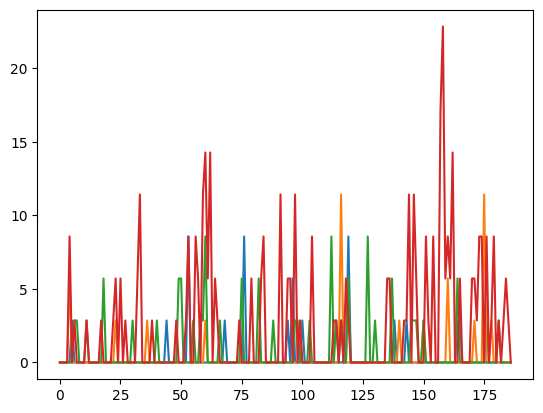

In [33]:
plt.figure()
plt.plot(X[:4][:,0].T)

In [34]:
# X = X.numpy() # was already numpy array from Matlab import
X = (X - np.mean(X, axis=1)[:,None,:])
# fill Nan with zero in X
X[np.isnan(X)] = 0
# y = y.numpy()
# DEVICE = mtr.set_device(use_GPU=True)
DEVICE = 'cuda:0'
# DEVICE = 'cpu'

# rearrange X so 3rd dimension becomes first dimension, 2nd dimension stays the same
# need first dimension to be labels and match len(y) before passing to CP_logistic_regression
X = np.moveaxis(X, 2, 0)
# get rid of 2nd dimension of y
y = y.squeeze()
# show shape of X
print(X.shape) # X is now classification dimension X time dimension X neurons
print(y.shape)

(491, 43, 15)
(491,)


In [60]:

# h_vals = np.logspace(-50, 2, num=30, endpoint=True, base=10.0)
# h_vals = np.int64(np.linspace(1, 300, num=30, endpoint=True))
h_vals = np.arange(1)

loss_all = []
for ii, val in enumerate(h_vals):
    print(f'hyperparameter val: {val}')
    cpmlr = mtr.CP_logistic_regression(
        X,
        y, 
        rank=6,
        non_negative=[True, True, True],
        weights=None,
        Bcp_init=None,
        Bcp_init_scale=1,
        device=DEVICE,
        softplus_kwargs={
            'beta': 50,
            'threshold':1
        }
    )

    # tic = time.time()
    # cpmlr.fit(lambda_L2=0.003, 
    #             max_iter=200, 
    #             tol=1e-50, 
    #             patience=10,
    #             verbose=1,
    #             running_loss_logging_interval=1,
    #             LBFGS_kwargs={
    #                 'lr' : 10000, 
    #                 'max_iter' : 20, 
    #                 'max_eval' : None, 
    #                 'tolerance_grad' : 1e-07, 
    #                 'tolerance_change' : 1e-09, 
    #                 'history_size' : 100, 
    #                 'line_search_fn' : "strong_wolfe"
    #             }
    #          )
    
    cpmlr.fit_Adam(lambda_L2=0.01, 
                max_iter=8000, 
                tol=1e-6, 
                patience=100,
                verbose=2,
                Adam_kwargs={
                        'lr' : 0.1, 
#                             'betas' : (0.9, 0.999), 
#                             'eps' : 1e-08, 
#                             'weight_decay' : 0, 
                        'amsgrad' : True
                    }
         )

    # print(time.time() - tic)
    print(f'loss: {cpmlr.loss_running[-1]}')
    
    loss_all.append(cpmlr.loss_running[-1])

hyperparameter val: 0
Iteration: 0, Loss: 1.6224524974822998
Iteration: 1, Loss: 1.569693684577942
Iteration: 2, Loss: 1.5349371433258057
Iteration: 3, Loss: 1.5115543603897095
Iteration: 4, Loss: 1.49077570438385
Iteration: 5, Loss: 1.4730652570724487
Iteration: 6, Loss: 1.4557216167449951
Iteration: 7, Loss: 1.4457862377166748
Iteration: 8, Loss: 1.4314613342285156
Iteration: 9, Loss: 1.4197875261306763
Iteration: 10, Loss: 1.408436894416809
Iteration: 11, Loss: 1.3972275257110596
Iteration: 12, Loss: 1.3893306255340576
Iteration: 13, Loss: 1.3815970420837402
Iteration: 14, Loss: 1.3757805824279785
Iteration: 15, Loss: 1.3706722259521484
Iteration: 16, Loss: 1.3656156063079834
Iteration: 17, Loss: 1.3620243072509766
Iteration: 18, Loss: 1.3567132949829102
Iteration: 19, Loss: 1.3511908054351807
Iteration: 20, Loss: 1.347537636756897
Iteration: 21, Loss: 1.3424164056777954
Iteration: 22, Loss: 1.3377670049667358
Iteration: 23, Loss: 1.3355778455734253
Iteration: 24, Loss: 1.3327035903

15
15


Text(0.5, 0.98, 'components')

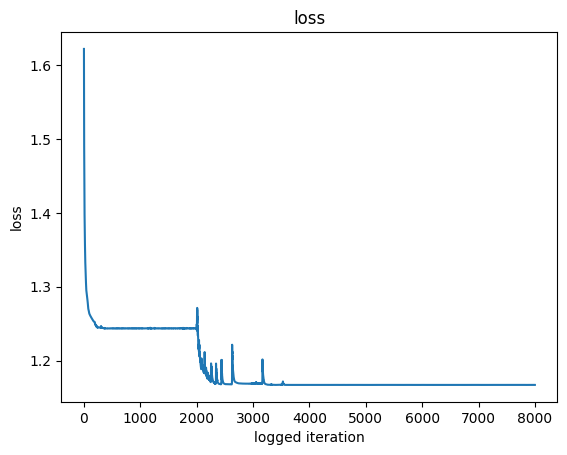

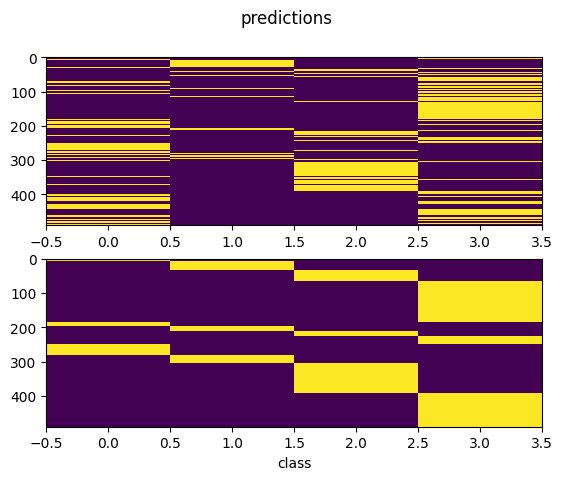

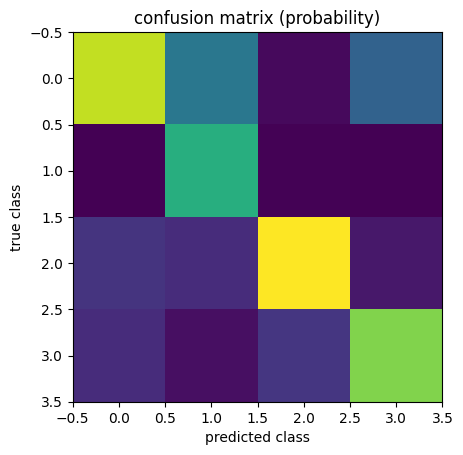

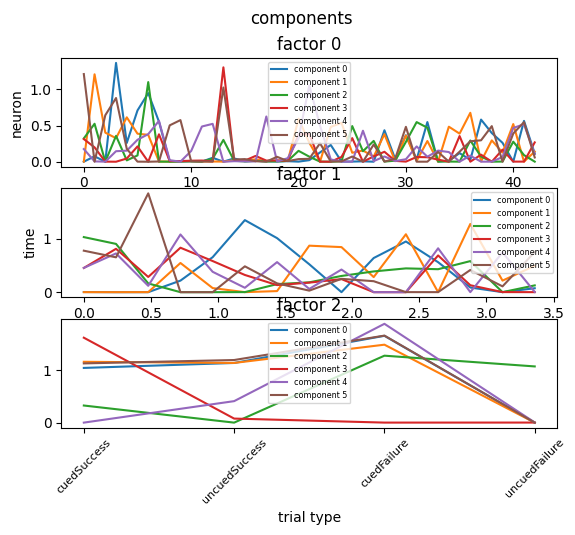

In [61]:
plt.figure()
plt.plot(cpmlr.loss_running)
plt.xlabel('logged iteration')
plt.ylabel('loss')
plt.title('loss')

prob, pred = cpmlr.predict()
fig, axs = plt.subplots(2)
axs[0].imshow(mtr.idx_to_oneHot(pred, cpmlr.n_classes), aspect='auto', interpolation='none')
axs[1].imshow(mtr.idx_to_oneHot(y, cpmlr.n_classes), aspect='auto', interpolation='none')
axs[1].set_xlabel('class')
fig.suptitle('predictions')

cm = cpmlr.make_confusion_matrix(prob_or_pred='pred')[0]
fig = plt.figure()
plt.imshow(cm)
plt.ylabel('true class')
plt.xlabel('predicted class')
plt.title('confusion matrix (probability)')

Bcp_final = cpmlr.return_Bcp_final()
fig, axs = plt.subplots(len(Bcp_final))
trialtypes = ['cuedSuccess', 'uncuedSuccess', 'cuedFailure', 'uncuedFailure']
for ii, val in enumerate(Bcp_final):
    axs[ii].set_title(f'factor {ii}')
    if ii == 0:
        axs[ii].set_ylabel('neuron')
        axs[ii].plot(val)
    if ii == 1:
        axs[ii].set_ylabel('time')
        print(len(timepoints))
        print(len(val))
        axs[ii].plot(timepoints, val) 
    if ii == 2:
        axs[ii].set_xlabel('trial type')
        axs[ii].plot(val)
        plt.xticks(range(0,len(val)), trialtypes, rotation=45)
        plt.tick_params(axis='x', labelsize=8)
    
    # add legend 
    axs[ii].legend([f'component {ii}' for ii in range(val.shape[1])], fontsize='xx-small')
fig.suptitle('components')